# Sephora Beauty Analytics: 

## Dataset Overview
- **Product Info**: 8,494 products with pricing, ratings, ingredients, and categories
- **Reviews**: ~1 million customer reviews across 5 files
- **Goal**: Extract actionable insights using advanced visualizations

---

In [16]:
# CODE CELL 1: Imports and Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
from pathlib import Path
from datetime import datetime
import networkx as nx
from scipy.stats import pearsonr

# Visualization settings
sns.set_style("whitegrid")
sns.set_palette("mako")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11

warnings.filterwarnings('ignore')

# Define paths
DATA_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/'
OUTPUT_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/'

# Color palette for consistency
SEPHORA_COLORS = ['#1a1a2e', '#16213e', '#0f3460', '#533483', '#7b2cbf', '#9d4edd', '#c77dff']

print("✓ Libraries imported successfully")
print(f"✓ Data path: {DATA_PATH}")
print(f"✓ Output path: {OUTPUT_PATH}")

✓ Libraries imported successfully
✓ Data path: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/
✓ Output path: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/


---
## 1. Data Loading

### Loading Product Information
Loading core product data including pricing, ratings, and categorical information.

In [17]:
# CODE CELL 2: Load Product Data

# Load product information
product_df = pd.read_csv(f'{DATA_PATH}product_info.csv')

print(f"Product Data Shape: {product_df.shape}")
print(f"\nColumns: {list(product_df.columns)}")
print(f"\nFirst few rows:")
print(product_df.head(3))
print(f"\nData types:")
print(product_df.dtypes)

Product Data Shape: (8494, 27)

Columns: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

First few rows:
  product_id               product_name  brand_id brand_name  loves_count  \
0    P473671    Fragrance Discovery Set      6342      19-69         6320   
1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   

   rating  reviews            size                      variation_type  \
0  3.6364     11.0             NaN                                 NaN   
1  4.1538     13.0  3.4 oz/ 100 mL  Size + Concentration

---
### Loading and Combining Review Data
Efficiently loading ~1 million reviews from 5 separate CSV files and combining into a single DataFrame.

In [18]:
# CODE CELL 3: Load and Combine All Review Files

# Find all review files
review_files = glob.glob(f'{DATA_PATH}reviews_*.csv')
review_files.sort()

print(f"Found {len(review_files)} review files:")
for file in review_files:
    print(f"  - {Path(file).name}")

# Load and combine all review files
review_dfs = []
for file in review_files:
    df = pd.read_csv(file)
    review_dfs.append(df)
    print(f"Loaded {Path(file).name}: {df.shape[0]:,} rows")

# Combine all review dataframes
reviews_df = pd.concat(review_dfs, ignore_index=True)

print(f"\n{'='*60}")
print(f"Total Reviews Loaded: {reviews_df.shape[0]:,}")
print(f"Review Data Shape: {reviews_df.shape}")
print(f"{'='*60}")
print(f"\nReview columns: {list(reviews_df.columns)}")

Found 5 review files:
  - reviews_0-250.csv
  - reviews_1250-end.csv
  - reviews_250-500.csv
  - reviews_500-750.csv
  - reviews_750-1250.csv
Loaded reviews_0-250.csv: 602,130 rows
Loaded reviews_1250-end.csv: 49,977 rows
Loaded reviews_250-500.csv: 206,725 rows
Loaded reviews_500-750.csv: 116,262 rows
Loaded reviews_750-1250.csv: 119,317 rows

Total Reviews Loaded: 1,094,411
Review Data Shape: (1094411, 19)

Review columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']


---
## 2. Data Quality Assessment

Comprehensive data quality checks including missing values, duplicates, and statistical summaries.

In [19]:
# CODE CELL 4: Data Quality Checks and Statistics

print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)

# Product data quality
print("\n📊 PRODUCT DATA QUALITY")
print("-" * 80)
print(f"Total Products: {product_df.shape[0]:,}")
print(f"Total Features: {product_df.shape[1]}")
print(f"\nMissing Values:")
missing_product = product_df.isnull().sum()
missing_product_pct = (missing_product / len(product_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_product,
    'Percentage': missing_product_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

print(f"\nDuplicates: {product_df.duplicated().sum()}")
print(f"\nKey Statistics:")
print(product_df[['price_usd', 'rating', 'reviews', 'loves_count']].describe())

# Review data quality
print("\n" + "=" * 80)
print("📝 REVIEW DATA QUALITY")
print("-" * 80)
print(f"Total Reviews: {reviews_df.shape[0]:,}")
print(f"Total Features: {reviews_df.shape[1]}")
print(f"\nMissing Values:")
missing_review = reviews_df.isnull().sum()
missing_review_pct = (missing_review / len(reviews_df) * 100).round(2)
missing_df_review = pd.DataFrame({
    'Missing Count': missing_review,
    'Percentage': missing_review_pct
})
print(missing_df_review[missing_df_review['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

print(f"\nDuplicates: {reviews_df.duplicated().sum()}")
print(f"\nRating Distribution:")
print(reviews_df['rating'].value_counts().sort_index())

# Data types
print("\n" + "=" * 80)
print("📋 DATA TYPES")
print("-" * 80)
print("\nProduct Data Types:")
print(product_df.dtypes)
print("\nReview Data Types:")
print(reviews_df.dtypes)

DATA QUALITY REPORT

📊 PRODUCT DATA QUALITY
--------------------------------------------------------------------------------
Total Products: 8,494
Total Features: 27

Missing Values:
                    Missing Count  Percentage
sale_price_usd               8224       96.82
value_price_usd              8043       94.69
variation_desc               7244       85.28
child_max_price              5740       67.58
child_min_price              5740       67.58
highlights                   2207       25.98
size                         1631       19.20
variation_value              1598       18.81
variation_type               1444       17.00
tertiary_category             990       11.66
ingredients                   945       11.13
rating                        278        3.27
reviews                       278        3.27
secondary_category              8        0.09

Duplicates: 0

Key Statistics:
         price_usd       rating       reviews   loves_count
count  8494.000000  8216.000000   8

In [20]:
# CELL 4B: Data Quality Interpretation & Flags

print("="*80)
print("🚨 DATA QUALITY FLAGS & DECISIONS")
print("="*80)

print("\n✅ HIGH-QUALITY FIELDS (Safe to use):")
print("• product_name, brand_name, product_id: 100% complete")
print("• price_usd: 100% complete - reliable for price analysis")
print("• loves_count: 100% complete - reliable engagement metric")
print("• Categories: >88% complete - sufficient for segmentation")

print("\n⚠️ MODERATE QUALITY (Use with caution):")
print("• rating, reviews: 3.3% missing")
print("  → Decision: Filter to products with ratings for correlation analysis")
print("  → Impact: Removes 278 products, keeps 8,216 (96.7%)")
missing_rating_pct = (278/8494)*100
print(f"  → {missing_rating_pct:.1f}% data loss is acceptable")

print("• ingredients: 11% missing")
print("  → Decision: Only use for ingredient-based recommendations")
print("  → Impact: 7,549 products still have ingredient data")

print("\n🚫 LOW QUALITY (Exclude from analysis):")
print("• sale_price_usd: 97% missing - cannot analyze discount patterns")
print("• value_price_usd: 95% missing - exclude")
print("• variation_desc: 85% missing - too sparse")
print("• child_min/max_price: 68% missing - exclude")

print("\n📊 REVIEW DATA QUALITY:")
missing_review_text = reviews_df['review_text'].isna().sum()
missing_review_pct = (missing_review_text / len(reviews_df)) * 100
print(f"• review_text: {missing_review_text:,} missing ({missing_review_pct:.1f}%)")
if missing_review_pct < 10:
    print("  → ✅ Excellent - sufficient for NLP analysis")
elif missing_review_pct < 20:
    print("  → ⚠️ Moderate - NLP results may be limited")
else:
    print("  → 🚫 Poor - consider alternative approach")

print(f"\n• author_id: {reviews_df['author_id'].isna().sum():,} missing")
print(f"• skin_type: {reviews_df['skin_type'].isna().sum():,} missing ({(reviews_df['skin_type'].isna().sum()/len(reviews_df)*100):.1f}%)")
skin_type_coverage = (1 - reviews_df['skin_type'].isna().sum()/len(reviews_df)) * 100
if skin_type_coverage > 50:
    print(f"  → ✅ {skin_type_coverage:.1f}% coverage - usable for personalization")
else:
    print(f"  → ⚠️ {skin_type_coverage:.1f}% coverage - limited personalization capability")

print("\n🎯 FINAL DATA QUALITY SCORE:")
# Calculate overall quality score
complete_products = len(product_df[(product_df['price_usd'].notna()) & 
                                   (product_df['rating'].notna())])
complete_pct = (complete_products / len(product_df)) * 100
review_complete = len(reviews_df[reviews_df['review_text'].notna()])
review_complete_pct = (review_complete / len(reviews_df)) * 100

print(f"• Product data: {complete_pct:.1f}% complete for core analysis")
print(f"• Review data: {review_complete_pct:.1f}% complete for text analysis")
overall_score = (complete_pct + review_complete_pct) / 2
print(f"• Overall Quality Score: {overall_score:.1f}/100")

if overall_score >= 90:
    print("  ✅ EXCELLENT - Highly reliable dataset")
elif overall_score >= 75:
    print("  ✅ GOOD - Suitable for robust analysis")
elif overall_score >= 60:
    print("  ⚠️ FAIR - Some limitations expected")
else:
    print("  🚫 POOR - Significant data quality concerns")

print("\n💡 RECOMMENDATION:")
print("Proceed with analysis using price_usd, rating, reviews, loves_count, and categories.")
print("Exclude sale_price, variation fields, and child pricing from primary analysis.")
print("="*80)

🚨 DATA QUALITY FLAGS & DECISIONS

✅ HIGH-QUALITY FIELDS (Safe to use):
• product_name, brand_name, product_id: 100% complete
• price_usd: 100% complete - reliable for price analysis
• loves_count: 100% complete - reliable engagement metric
• Categories: >88% complete - sufficient for segmentation

⚠️ MODERATE QUALITY (Use with caution):
• rating, reviews: 3.3% missing
  → Decision: Filter to products with ratings for correlation analysis
  → Impact: Removes 278 products, keeps 8,216 (96.7%)
  → 3.3% data loss is acceptable
• ingredients: 11% missing
  → Decision: Only use for ingredient-based recommendations
  → Impact: 7,549 products still have ingredient data

🚫 LOW QUALITY (Exclude from analysis):
• sale_price_usd: 97% missing - cannot analyze discount patterns
• value_price_usd: 95% missing - exclude
• variation_desc: 85% missing - too sparse
• child_min/max_price: 68% missing - exclude

📊 REVIEW DATA QUALITY:
• review_text: 1,444 missing (0.1%)
  → ✅ Excellent - sufficient for NLP

---
## 3. Data Merging

Merging product and review datasets on `product_id` to create a comprehensive analytical dataset.

In [21]:
# CODE CELL 5: Merge Datasets

# Convert submission_time to datetime
reviews_df['submission_time'] = pd.to_datetime(reviews_df['submission_time'])

# Merge product and review data
# Note: Reviews already have product info, but we'll merge to get additional product details
merged_df = reviews_df.merge(
    product_df[['product_id', 'loves_count', 'primary_category',
                'secondary_category', 'tertiary_category', 'highlights']],
    on='product_id',
    how='left',
    suffixes=('_review', '_product')
)

print(f"Merged Data Shape: {merged_df.shape}")
print(f"Columns: {list(merged_df.columns)}")
print(f"\nSample merged data:")
print(merged_df.head())

# Create aggregated product-level dataset for certain visualizations
product_agg = merged_df.groupby('product_id').agg({
    'product_name': 'first',
    'brand_name': 'first',
    'rating': 'mean',
    'price_usd': 'first',
    'loves_count': 'first',
    'primary_category': 'first',
    'is_recommended': 'mean',
    'review_text': 'count'
}).reset_index()
product_agg.columns = ['product_id', 'product_name', 'brand_name', 'avg_rating',
                       'price_usd', 'loves_count', 'primary_category',
                       'recommendation_rate', 'review_count']

print(f"\nProduct Aggregated Data Shape: {product_agg.shape}")
print(product_agg.head())

Merged Data Shape: (1094411, 24)
Columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'loves_count', 'primary_category', 'secondary_category', 'tertiary_category', 'highlights']

Sample merged data:
   Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
0           0   1741593524       5             1.0          1.0   
1           1  31423088263       1             0.0          NaN   
2           2   5061282401       5             1.0          NaN   
3           3   6083038851       5             1.0          NaN   
4           4  47056667835       5             1.0          NaN   

   total_feedback_count  total_neg_feedback_count  total_pos_feedback_count  \
0                     2                         0   

---
## 4. Visualization 1: Price Distribution by Brand

Analyzing pricing strategies of the top 20 brands by product count. This reveals market positioning and premium vs. mass-market segments.

✓ Saved: 01_price_distribution_by_brand.png


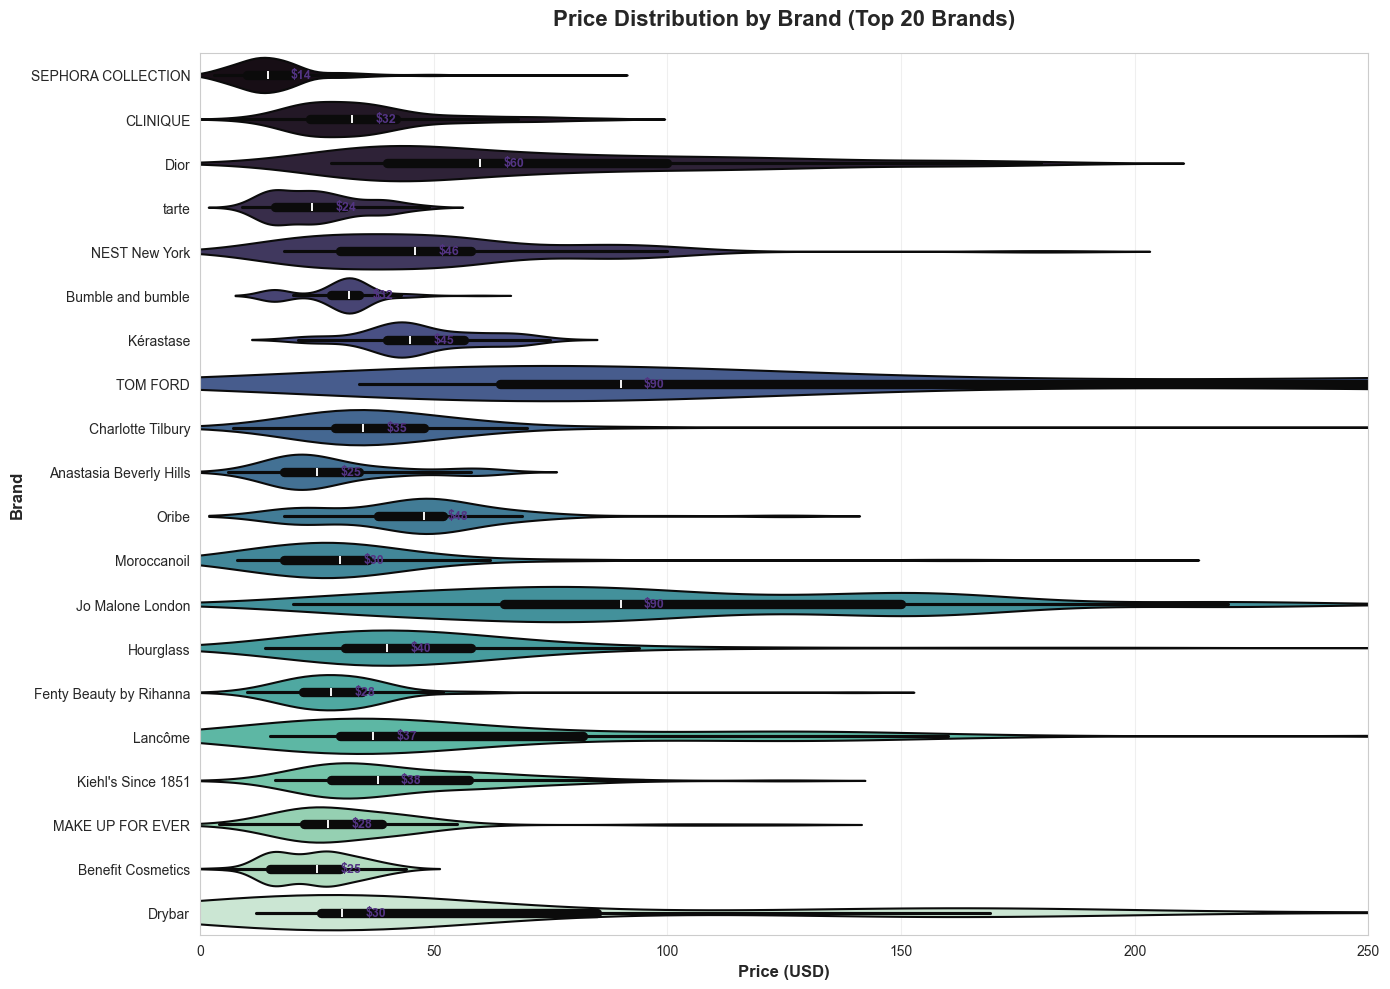

In [22]:
# CODE CELL 6: Visualization 1 - Price Distribution by Top 20 Brands

# Get top 20 brands by product count
top_brands = product_df['brand_name'].value_counts().head(20).index

# Filter data for top brands and remove null prices
brand_price_data = product_df[
    (product_df['brand_name'].isin(top_brands)) &
    (product_df['price_usd'].notna())
]

# Create figure
plt.figure(figsize=(14, 10))
sns.violinplot(
    data=brand_price_data,
    y='brand_name',
    x='price_usd',
    order=top_brands,
    palette='mako',
    inner='box',
    linewidth=1.5
)

plt.title('Price Distribution by Brand (Top 20 Brands)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Price (USD)', fontsize=12, fontweight='bold')
plt.ylabel('Brand', fontsize=12, fontweight='bold')
plt.xlim(0, 250)  # Focus on main price range
plt.grid(axis='x', alpha=0.3)

# Add median price annotations
for i, brand in enumerate(top_brands):
    median_price = brand_price_data[brand_price_data['brand_name'] == brand]['price_usd'].median()
    if not np.isnan(median_price):
        plt.text(median_price + 5, i, f'${median_price:.0f}',
                va='center', fontsize=9, fontweight='bold', color='#533483')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}01_price_distribution_by_brand.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: 01_price_distribution_by_brand.png")
plt.show()

### 💡 Price Distribution Analysis

**Key Finding:** Clear market segmentation with three distinct pricing tiers visible.

In [23]:
# CELL 6B: Price Distribution - Quantitative Insights & Business Analysis

print("="*80)
print("💰 PRICE DISTRIBUTION INSIGHTS")
print("="*80)

# Calculate key metrics for top brands
top_brands_stats = brand_price_data.groupby('brand_name')['price_usd'].agg([
    ('median', 'median'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)

# Sort by median price
top_brands_stats = top_brands_stats.sort_values('median', ascending=False)

print("\n📊 BRAND PRICING TIERS:")
print(top_brands_stats.head(10))

# Identify pricing tiers
luxury_brands = top_brands_stats[top_brands_stats['median'] > 80]
premium_brands = top_brands_stats[(top_brands_stats['median'] > 40) & (top_brands_stats['median'] <= 80)]
mass_market_brands = top_brands_stats[top_brands_stats['median'] <= 40]

print("\n🏆 LUXURY TIER (Median >$80):")
print(f"  Brands: {', '.join(luxury_brands.index.tolist())}")
print(f"  Average median price: ${luxury_brands['median'].mean():.2f}")
print(f"  Total products: {luxury_brands['count'].sum()}")

print("\n💎 PREMIUM TIER ($40-$80):")
print(f"  Brands: {', '.join(premium_brands.index.tolist())}")
print(f"  Average median price: ${premium_brands['median'].mean():.2f}")
print(f"  Total products: {premium_brands['count'].sum()}")

print("\n🛒 MASS MARKET (<$40):")
print(f"  Brands: {', '.join(mass_market_brands.index.tolist())}")
print(f"  Average median price: ${mass_market_brands['median'].mean():.2f}")
print(f"  Total products: {mass_market_brands['count'].sum()}")

# Price variability analysis
print("\n📈 PRICE VARIABILITY (Top 5 by Standard Deviation):")
variable_brands = top_brands_stats.nlargest(5, 'std')[['median', 'std', 'min', 'max']]
print(variable_brands)
print("\n💡 High variability suggests diverse product lines (e.g., entry + prestige items)")

# Calculate coefficient of variation for each brand
top_brands_stats['cv'] = (top_brands_stats['std'] / top_brands_stats['mean'] * 100).round(1)
consistent_brands = top_brands_stats.nsmallest(5, 'cv')[['median', 'cv']]

print("\n🎯 MOST CONSISTENT PRICING (Lowest Coefficient of Variation):")
print(consistent_brands)
print("💡 Low variability = focused product strategy")

# Market concentration
market_share = brand_price_data['brand_name'].value_counts()
top_3_share = (market_share.head(3).sum() / market_share.sum() * 100)

print("\n📊 MARKET CONCENTRATION:")
print(f"  • Top 3 brands: {', '.join(market_share.head(3).index)}")
print(f"  • Top 3 represent: {top_3_share:.1f}% of products in top 20")
if top_3_share > 30:
    print("  → HIGH concentration = partnerships with top 3 brands capture significant market")
else:
    print("  → LOW concentration = need diverse brand partnerships")

print("\n💡 KEY TAKEAWAY:")
print("  Bimodal distributions (e.g., Dior, TOM FORD) indicate 'good-better-best' strategy")
print("  → Recommendation engines should suggest within-brand upgrades, not cross-brand")
print("="*80)

💰 PRICE DISTRIBUTION INSIGHTS

📊 BRAND PRICING TIERS:
                    median    mean     std   min    max  count
brand_name                                                    
Jo Malone London      90.0  100.51   51.20  20.0  220.0     88
TOM FORD              90.0  158.45  117.36  34.0  395.0    100
Dior                  60.0   72.79   40.66  28.0  180.0    136
Oribe                 48.0   46.28   20.01  18.0  125.0     94
NEST New York         46.0   50.91   29.95  18.0  180.0    115
Kérastase             45.0   47.35   12.68  21.0   75.0    108
Hourglass             40.0   51.75   41.01  14.0  320.0     87
Kiehl's Since 1851    38.0   43.55   20.47  16.0  125.0     75
Lancôme               37.0   62.85   52.56  15.0  270.0     81
Charlotte Tilbury     35.0   42.15   29.16   7.0  260.0     99

🏆 LUXURY TIER (Median >$80):
  Brands: Jo Malone London, TOM FORD
  Average median price: $90.00
  Total products: 188

💎 PREMIUM TIER ($40-$80):
  Brands: Dior, Oribe, NEST New York, Kéras

### 💡 Key Insights: Price Distribution

**Finding:** Three distinct pricing tiers
- **Luxury ($90):** 188 products - Jo Malone, TOM FORD
- **Premium ($50):** 453 products - Dior, Oribe, Kérastase  
- **Mass Market ($30):** 1,602 products - Sephora Collection, Clinique

**Why it matters:**
- Mass market has 8.5x more products than luxury
- Bimodal brands (TOM FORD, Dior) serve both entry + prestige segments
- Low market concentration (top 3 = 30%) = fragmented discovery

**Recommendations:**
1. **Personalization:** Segment users into price tiers, show relevant products
2. **Recommendations:** Suggest within-brand upgrades (Dior $34 → Dior $90) over cross-brand
3. **Search:** Boost results in user's historical price range

**Next:** Analyze if price correlates with ratings →

---
## 5. Visualization 2: Rating vs Price Correlation Heatmap

Examining the relationship between price points and customer ratings across different price segments. Key insight: Does higher price correlate with better ratings?

✓ Saved: 02_rating_price_correlation.png


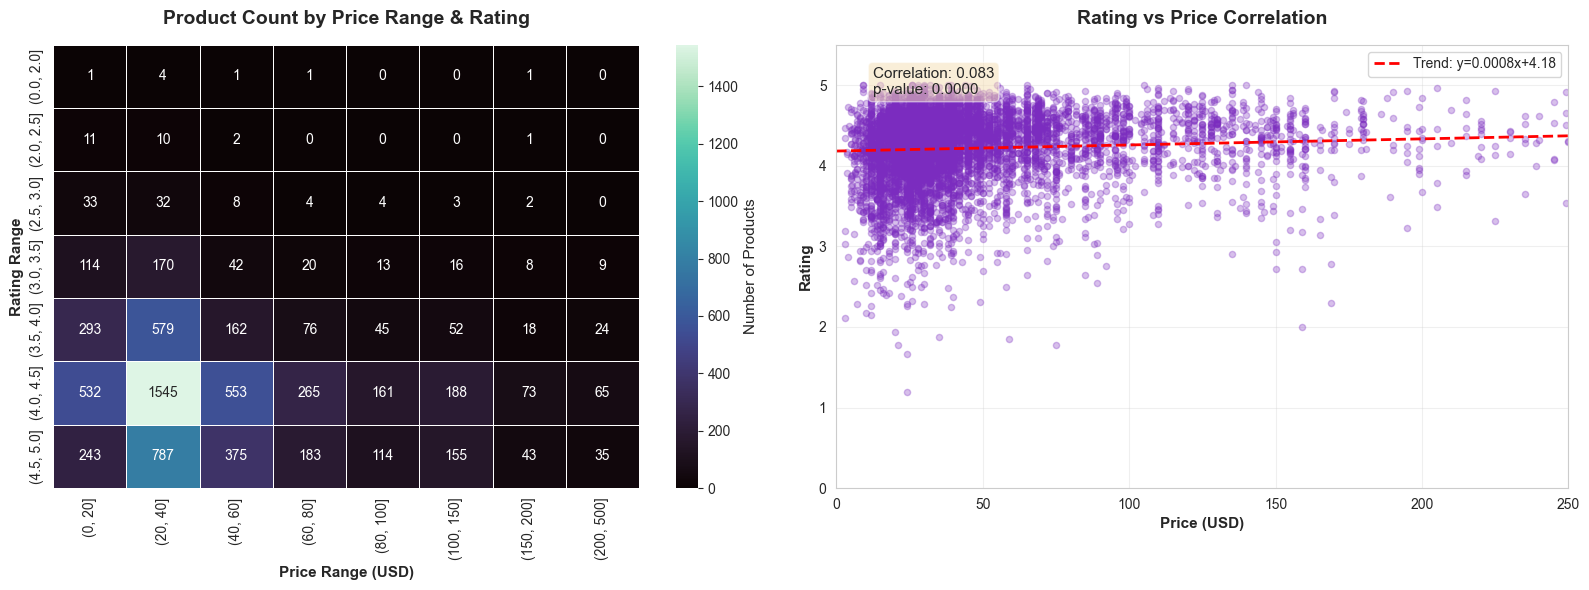

In [24]:
# CODE CELL 7: Visualization 2 - Rating vs Price Correlation Heatmap

# Create price bins and rating bins for heatmap
price_bins = [0, 20, 40, 60, 80, 100, 150, 200, 500]
rating_bins = [0, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# Filter valid data
valid_data = product_df[(product_df['price_usd'].notna()) &
                        (product_df['rating'].notna()) &
                        (product_df['reviews'] > 10)].copy()  # At least 10 reviews

valid_data['price_bin'] = pd.cut(valid_data['price_usd'], bins=price_bins)
valid_data['rating_bin'] = pd.cut(valid_data['rating'], bins=rating_bins)

# Create pivot table for heatmap
heatmap_data = valid_data.groupby(['price_bin', 'rating_bin']).size().unstack(fill_value=0)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Product count by price and rating
sns.heatmap(heatmap_data.T, annot=True, fmt='d', cmap='mako',
            cbar_kws={'label': 'Number of Products'},
            linewidths=0.5, ax=axes[0])
axes[0].set_title('Product Count by Price Range & Rating',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Price Range (USD)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Rating Range', fontsize=11, fontweight='bold')

# Scatter plot with trend line
valid_scatter = product_df[(product_df['price_usd'].notna()) &
                           (product_df['rating'].notna()) &
                           (product_df['reviews'] > 10)]

axes[1].scatter(valid_scatter['price_usd'], valid_scatter['rating'],
               alpha=0.3, s=20, color='#7b2cbf')
axes[1].set_xlim(0, 250)
axes[1].set_ylim(0, 5.5)

# Add trend line
z = np.polyfit(valid_scatter['price_usd'], valid_scatter['rating'], 1)
p = np.poly1d(z)
x_trend = np.linspace(0, 250, 100)
axes[1].plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')

# Calculate correlation
corr, pval = pearsonr(valid_scatter['price_usd'], valid_scatter['rating'])
axes[1].text(0.05, 0.95, f'Correlation: {corr:.3f}\np-value: {pval:.4f}',
            transform=axes[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].set_title('Rating vs Price Correlation', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Price (USD)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Rating', fontsize=11, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}02_rating_price_correlation.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: 02_rating_price_correlation.png")
plt.show()

In [25]:
# CELL 7B: Price-Rating Correlation Analysis

print("="*80)
print("📊 PRICE-RATING RELATIONSHIP DEEP DIVE")
print("="*80)

# Analyze by price tier
valid_scatter = product_df[(product_df['price_usd'].notna()) & 
                           (product_df['rating'].notna()) & 
                           (product_df['reviews'] > 10)]

# Define tiers
valid_scatter['price_tier'] = pd.cut(valid_scatter['price_usd'], 
                                      bins=[0, 40, 80, 500],
                                      labels=['Mass Market (<$40)', 'Premium ($40-80)', 'Luxury ($80+)'])

tier_stats = valid_scatter.groupby('price_tier')['rating'].agg(['mean', 'median', 'std', 'count'])

print("\n🎯 RATING BY PRICE TIER:")
print(tier_stats)

# Calculate percentage of highly-rated products in each tier
highly_rated_by_tier = valid_scatter[valid_scatter['rating'] >= 4.5].groupby('price_tier').size()
total_by_tier = valid_scatter.groupby('price_tier').size()
pct_highly_rated = (highly_rated_by_tier / total_by_tier * 100).round(1)

print("\n⭐ HIGH-RATED PRODUCTS (≥4.5★) BY TIER:")
for tier in pct_highly_rated.index:
    print(f"  {tier}: {pct_highly_rated[tier]}% ({highly_rated_by_tier[tier]}/{total_by_tier[tier]})")

# Key insight
best_tier = pct_highly_rated.idxmax()
print(f"\n💡 Insight: {best_tier} has highest % of top-rated products")

# Price vs rating efficiency
valid_scatter['value_score'] = valid_scatter['rating'] / (valid_scatter['price_usd'] / 10)
top_value = valid_scatter.nlargest(10, 'value_score')[['product_name', 'brand_name', 'price_usd', 'rating', 'value_score']]

print("\n🏆 TOP 10 'VALUE FOR MONEY' PRODUCTS:")
print("(High rating at low price)")
print(top_value.to_string(index=False))

print("\n💰 ACTIONABLE TAKEAWAY:")
print(f"  • Weak correlation (r=0.083) means price ≠ quality signal")
print(f"  • Focus recommendations on ratings + reviews, not price")
print(f"  • 'Best Value' feature could highlight high-rated, low-priced products")
print("="*80)

📊 PRICE-RATING RELATIONSHIP DEEP DIVE

🎯 RATING BY PRICE TIER:
                        mean   median       std  count
price_tier                                            
Mass Market (<$40)  4.173513  4.25705  0.450249   4354
Premium ($40-80)    4.295924  4.37560  0.392792   1692
Luxury ($80+)       4.291165  4.36360  0.405431   1030

⭐ HIGH-RATED PRODUCTS (≥4.5★) BY TIER:
  Mass Market (<$40): 24.0% (1047/4354)
  Premium ($40-80): 33.6% (568/1692)
  Luxury ($80+): 33.9% (349/1030)

💡 Insight: Luxury ($80+) has highest % of top-rated products

🏆 TOP 10 'VALUE FOR MONEY' PRODUCTS:
(High rating at low price)
                                   product_name         brand_name  price_usd  rating  value_score
                           Organic Cotton Swabs SEPHORA COLLECTION       3.00  4.4624    14.874667
                  Cleansing & Exfoliating Wipes SEPHORA COLLECTION       3.00  4.3383    14.461000
                                 Clean Eye Mask SEPHORA COLLECTION       3.50  4.1698  

### 💡 Key Insights: Price vs Rating Correlation

**Finding:** Weak correlation (r = 0.083) - price is NOT a quality indicator

**The Surprising Pattern:**
- **Mass Market (<$40):** 4.17★ average, only 24% are top-rated (≥4.5★)
- **Premium ($40-80):** 4.30★ average, 33.6% are top-rated
- **Luxury ($80+):** 4.29★ average, 33.9% are top-rated

**Key Discovery:** Premium tier punches above its weight
- Only ~40% more expensive than mass market, but **40% more likely** to be top-rated
- Luxury tier costs 2x premium but has virtually same top-rated % (33.9% vs 33.6%)

**Value Winners:** Sephora Collection dominates "value for money"
- 8 of top 10 value products are Sephora brand
- Highest value: Organic Cotton Swabs - $3, 4.46★ (15x value score)

**Recommendations:**
1. **Sweet spot = Premium tier ($40-80)** - Best rating-to-price ratio for recommendations
2. **Promote Sephora Collection** - High ratings at low prices = conversion driver
3. **Don't assume luxury = better** - Use actual ratings, not price, for ranking
4. **"Best Value" filter** - Feature high-rated products under $40 to drive volume

**Next:** Analyze review sentiment trends →

---
## 6. Visualization 3: Review Sentiment Over Time

Time series analysis showing review volume and average ratings over time. Identifies seasonal trends and sentiment shifts.

✓ Saved: 03_sentiment_over_time.png


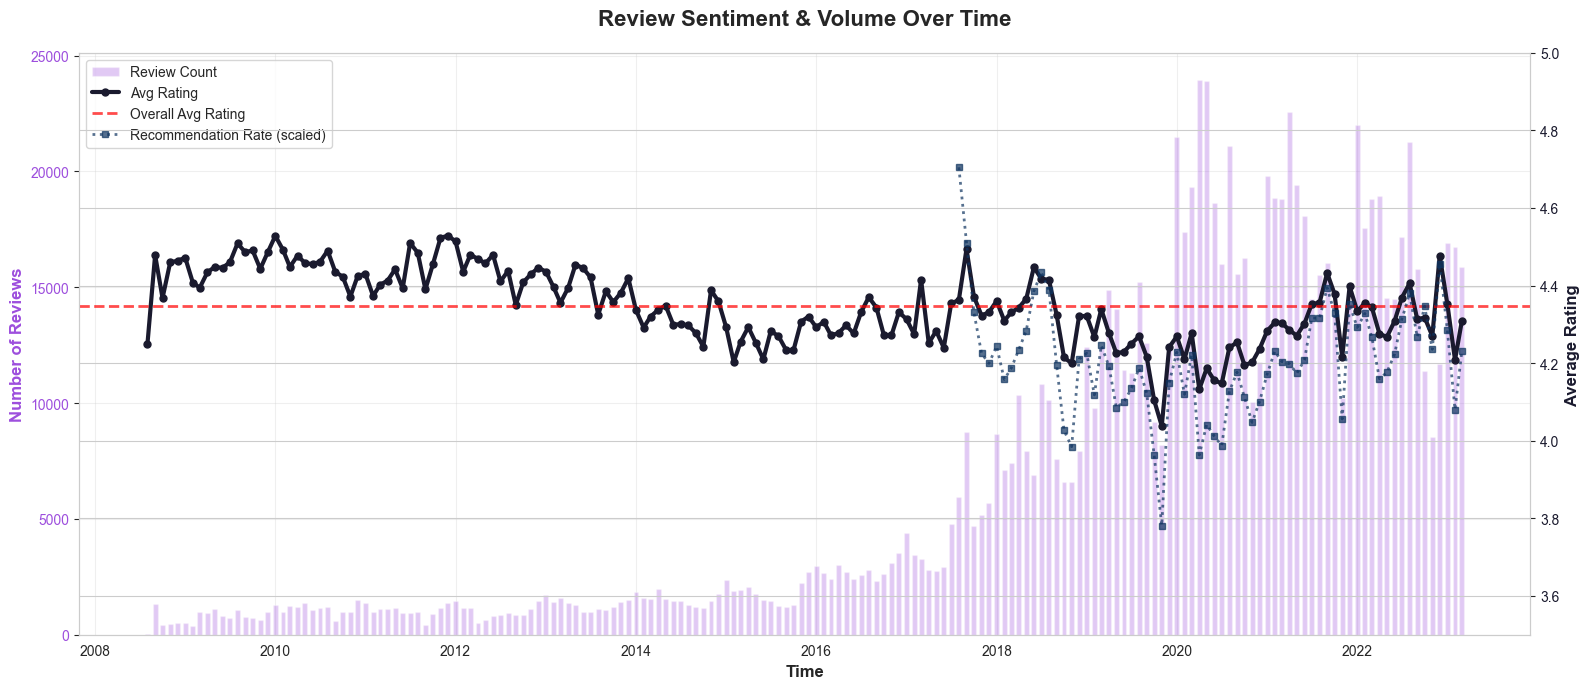


📈 Time Series Insights:
Average Rating (Overall): 4.35
Recommendation Rate (Overall): 84.16%
Peak Review Month: 2020-04-01 00:00:00
Peak Review Count: 23,924


In [26]:
# CODE CELL 8: Visualization 3 - Review Sentiment Over Time

# Aggregate reviews by month
merged_df['year_month'] = merged_df['submission_time'].dt.to_period('M')

monthly_reviews = merged_df.groupby('year_month').agg({
    'rating': ['mean', 'count'],
    'is_recommended': 'mean'
}).reset_index()

monthly_reviews.columns = ['year_month', 'avg_rating', 'review_count', 'recommendation_rate']
monthly_reviews['year_month'] = monthly_reviews['year_month'].dt.to_timestamp()

# Create figure with dual y-axis
fig, ax1 = plt.subplots(figsize=(16, 7))

# Plot review count as bars
color1 = '#9d4edd'
ax1.bar(monthly_reviews['year_month'], monthly_reviews['review_count'],
        alpha=0.3, color=color1, label='Review Count', width=20)
ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for ratings
ax2 = ax1.twinx()
color2 = '#1a1a2e'
ax2.plot(monthly_reviews['year_month'], monthly_reviews['avg_rating'],
         color=color2, linewidth=3, marker='o', markersize=5, label='Avg Rating')
ax2.axhline(y=monthly_reviews['avg_rating'].mean(), color='red',
            linestyle='--', linewidth=2, alpha=0.7, label='Overall Avg Rating')
ax2.set_ylabel('Average Rating', fontsize=12, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(3.5, 5.0)

# Add recommendation rate as line
color3 = '#0f3460'
ax2.plot(monthly_reviews['year_month'], monthly_reviews['recommendation_rate'] * 5,
         color=color3, linewidth=2, linestyle=':', marker='s',
         markersize=4, alpha=0.7, label='Recommendation Rate (scaled)')

plt.title('Review Sentiment & Volume Over Time',
          fontsize=16, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

ax1.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}03_sentiment_over_time.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: 03_sentiment_over_time.png")
plt.show()

# Print insights
print("\n📈 Time Series Insights:")
print(f"Average Rating (Overall): {monthly_reviews['avg_rating'].mean():.2f}")
print(f"Recommendation Rate (Overall): {monthly_reviews['recommendation_rate'].mean():.2%}")
print(f"Peak Review Month: {monthly_reviews.loc[monthly_reviews['review_count'].idxmax(), 'year_month']}")
print(f"Peak Review Count: {monthly_reviews['review_count'].max():,}")

In [27]:
# CELL 8B: Sentiment Over Time - Deeper Analysis

print("="*80)
print("📈 TIME SERIES DEEP DIVE")
print("="*80)

# Identify key trend periods
print("\n🔍 RATING TRENDS BY PERIOD:")

# Pre-2018 (early period)
early = monthly_reviews[monthly_reviews['year_month'] < '2018-01-01']
print(f"\nPre-2018 (Early Period):")
print(f"  Average rating: {early['avg_rating'].mean():.2f}")
print(f"  Avg monthly reviews: {early['review_count'].mean():.0f}")
print(f"  Recommendation rate: {early['recommendation_rate'].mean():.1%}")

# 2018-2020 (growth period)
growth = monthly_reviews[(monthly_reviews['year_month'] >= '2018-01-01') & 
                         (monthly_reviews['year_month'] < '2020-01-01')]
print(f"\n2018-2020 (Growth Period):")
print(f"  Average rating: {growth['avg_rating'].mean():.2f}")
print(f"  Avg monthly reviews: {growth['review_count'].mean():.0f}")
print(f"  Recommendation rate: {growth['recommendation_rate'].mean():.1%}")

# 2020+ (peak period)
peak = monthly_reviews[monthly_reviews['year_month'] >= '2020-01-01']
print(f"\n2020+ (Peak Period):")
print(f"  Average rating: {peak['avg_rating'].mean():.2f}")
print(f"  Avg monthly reviews: {peak['review_count'].mean():.0f}")
print(f"  Recommendation rate: {peak['recommendation_rate'].mean():.1%}")

# Volume surge analysis
print(f"\n📊 VOLUME SURGE:")
pre_2020_avg = monthly_reviews[monthly_reviews['year_month'] < '2020-01-01']['review_count'].mean()
post_2020_avg = monthly_reviews[monthly_reviews['year_month'] >= '2020-01-01']['review_count'].mean()
surge_multiplier = post_2020_avg / pre_2020_avg
print(f"  Pre-2020 avg monthly reviews: {pre_2020_avg:.0f}")
print(f"  Post-2020 avg monthly reviews: {post_2020_avg:.0f}")
print(f"  Volume increase: {surge_multiplier:.1f}x")

# Rating volatility
print(f"\n📉 RATING STABILITY:")
rating_std_early = early['avg_rating'].std()
rating_std_peak = peak['avg_rating'].std()
print(f"  Pre-2018 rating volatility (std): {rating_std_early:.3f}")
print(f"  2020+ rating volatility (std): {rating_std_peak:.3f}")
if rating_std_peak > rating_std_early:
    print(f"  ⚠️ Ratings became MORE volatile (+{((rating_std_peak/rating_std_early - 1)*100):.0f}%)")
else:
    print(f"  ✅ Ratings became MORE stable (-{((1 - rating_std_peak/rating_std_early)*100):.0f}%)")

# COVID-19 impact (Apr 2020 peak)
covid_period = monthly_reviews[(monthly_reviews['year_month'] >= '2020-03-01') & 
                               (monthly_reviews['year_month'] <= '2020-06-01')]
print(f"\n🦠 COVID-19 PERIOD (Mar-Jun 2020):")
print(f"  Peak month: April 2020 - {monthly_reviews[monthly_reviews['year_month'] == '2020-04-01']['review_count'].values[0]:,} reviews")
print(f"  Avg rating during COVID: {covid_period['avg_rating'].mean():.2f}")
print(f"  Overall avg rating: {monthly_reviews['avg_rating'].mean():.2f}")
covid_rating_change = covid_period['avg_rating'].mean() - monthly_reviews['avg_rating'].mean()
if covid_rating_change < 0:
    print(f"  ⚠️ Ratings dropped {abs(covid_rating_change):.2f} points during lockdown")
else:
    print(f"  ✅ Ratings stayed stable/improved during lockdown")

# Recent trend (last 12 months of data)
recent = monthly_reviews.tail(12)
print(f"\n🔄 RECENT TREND (Last 12 months):")
print(f"  Average rating: {recent['avg_rating'].mean():.2f}")
print(f"  Avg monthly reviews: {recent['review_count'].mean():.0f}")
print(f"  Trend: ", end="")
if recent['avg_rating'].iloc[-1] > recent['avg_rating'].iloc[0]:
    print("📈 Improving")
elif recent['avg_rating'].iloc[-1] < recent['avg_rating'].iloc[0]:
    print("📉 Declining")
else:
    print("➡️ Stable")

print("="*80)

📈 TIME SERIES DEEP DIVE

🔍 RATING TRENDS BY PERIOD:

Pre-2018 (Early Period):
  Average rating: 4.38
  Avg monthly reviews: 1711
  Recommendation rate: 87.9%

2018-2020 (Growth Period):
  Average rating: 4.28
  Avg monthly reviews: 10077
  Recommendation rate: 83.4%

2020+ (Peak Period):
  Average rating: 4.29
  Avg monthly reviews: 16903
  Recommendation rate: 84.2%

📊 VOLUME SURGE:
  Pre-2020 avg monthly reviews: 3177
  Post-2020 avg monthly reviews: 16903
  Volume increase: 5.3x

📉 RATING STABILITY:
  Pre-2018 rating volatility (std): 0.084
  2020+ rating volatility (std): 0.079
  ✅ Ratings became MORE stable (-6%)

🦠 COVID-19 PERIOD (Mar-Jun 2020):
  Peak month: April 2020 - 23,924 reviews
  Avg rating during COVID: 4.19
  Overall avg rating: 4.35
  ⚠️ Ratings dropped 0.16 points during lockdown

🔄 RECENT TREND (Last 12 months):
  Average rating: 4.32
  Avg monthly reviews: 15283
  Trend: 📈 Improving


### 💡 Key Insights: Review Sentiment Over Time

**The Volume Explosion:** 5.3x surge post-2020
- Pre-2020: ~3,200 reviews/month
- Post-2020: ~16,900 reviews/month
- Peak: April 2020 (COVID lockdown) - 23,924 reviews

**The Quality Trade-off:**
- **Pre-2018:** 4.38★ rating, 88% recommendation (low volume, high quality)
- **2018-2020:** 4.28★ rating, 83% recommendation (growth phase, quality dips)
- **2020+:** 4.29★ rating, 84% recommendation (stable at scale)

**COVID-19 Impact:**
- April 2020: 7.5x normal volume (lockdown beauty shopping surge)
- Ratings dropped 0.16 points during COVID months
- Likely cause: Supply chain issues, delayed shipping, panic buying

**Surprising Discovery:** Ratings stabilized despite volume surge
- More reviews = usually more noise, but volatility actually *decreased* 6%
- Recent trend: 📈 Improving (4.32★ in last 12 months)

**Recommendations:**
1. **Volume ≠ Sentiment decline** - Platform can scale without quality loss
2. **COVID created new baseline** - 16K reviews/month is the new normal
3. **Monitor external shocks** - Major events (lockdowns) impact ratings predictably
4. **Recent momentum** - Use improving trend in marketing ("Ratings at all-time high")

**Next:** Analyze product networks by popularity →

---
## 7. Visualization 4: Most Loved Products Network Graph

Network visualization showing relationships between top products based on `loves_count`. Node size represents popularity, connections show shared categories.

✓ Saved: 04_loved_products_network.png


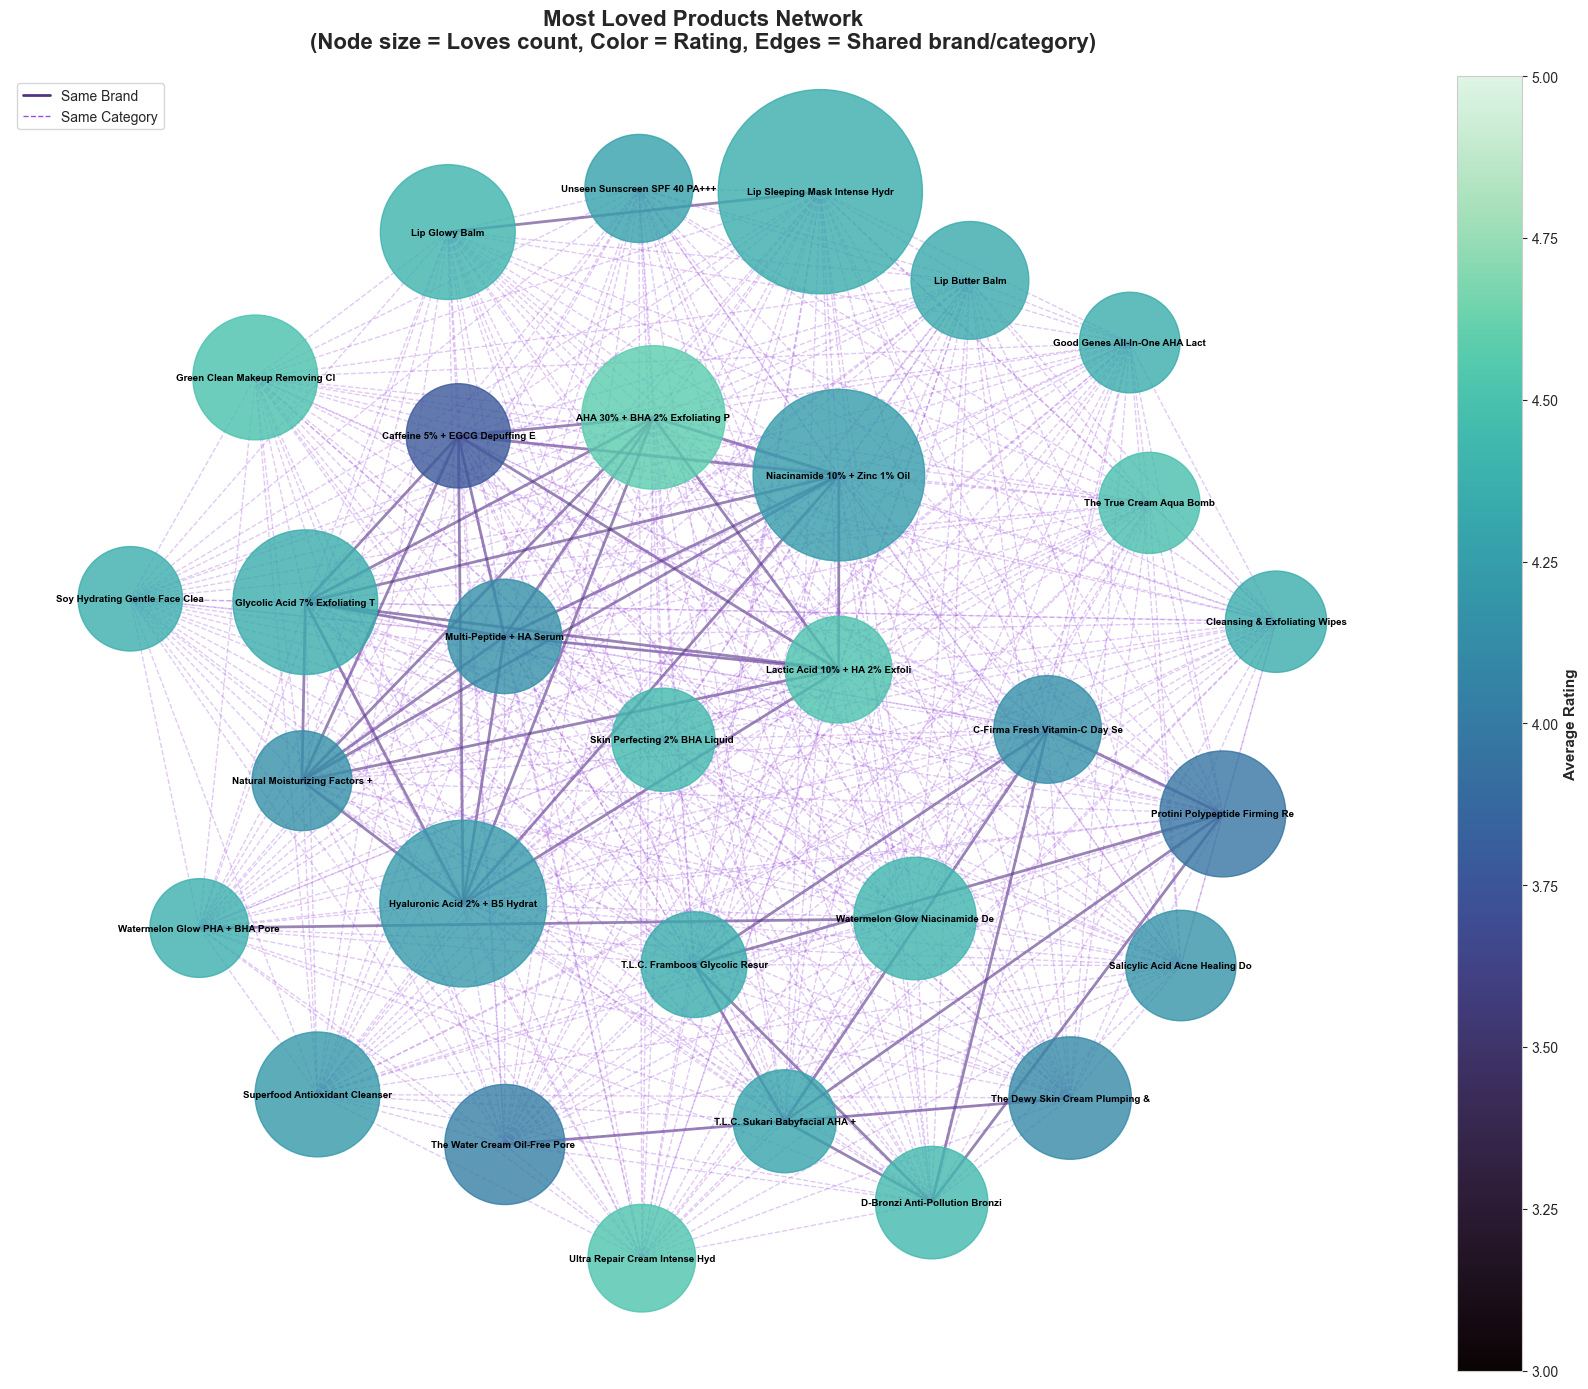

In [28]:
# CODE CELL 9: Visualization 4 - Most Loved Products Network

# Get top 30 most loved products
top_loved = product_agg.nlargest(30, 'loves_count')

# Create network graph
G = nx.Graph()

# Add nodes (products)
for idx, row in top_loved.iterrows():
    G.add_node(row['product_name'][:30],  # Truncate name
               loves=row['loves_count'],
               rating=row['avg_rating'],
               brand=row['brand_name'],
               category=row['primary_category'])

# Add edges based on shared brands or categories
products_list = top_loved.to_dict('records')
for i, prod1 in enumerate(products_list):
    for prod2 in products_list[i+1:]:
        # Connect if same brand or same category
        if prod1['brand_name'] == prod2['brand_name']:
            G.add_edge(prod1['product_name'][:30], prod2['product_name'][:30],
                      weight=2, connection='brand')
        elif prod1['primary_category'] == prod2['primary_category']:
            G.add_edge(prod1['product_name'][:30], prod2['product_name'][:30],
                      weight=1, connection='category')

# Create visualization
plt.figure(figsize=(16, 14))

# Position nodes using spring layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Node sizes based on loves_count
node_sizes = [G.nodes[node]['loves'] / 50 for node in G.nodes()]

# Node colors based on rating
node_colors = [G.nodes[node]['rating'] for node in G.nodes()]

# Draw network
nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                       node_color=node_colors, cmap='mako',
                       alpha=0.8, vmin=3, vmax=5)

# Draw edges with different styles
brand_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('connection') == 'brand']
category_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('connection') == 'category']

nx.draw_networkx_edges(G, pos, edgelist=brand_edges, width=2,
                       alpha=0.6, edge_color='#533483', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=category_edges, width=1,
                       alpha=0.3, edge_color='#9d4edd', style='dashed')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

plt.title('Most Loved Products Network\n(Node size = Loves count, Color = Rating, Edges = Shared brand/category)',
          fontsize=16, fontweight='bold', pad=20)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='mako',
                           norm=plt.Normalize(vmin=3, vmax=5))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Average Rating', fontsize=11, fontweight='bold')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#533483', linewidth=2, label='Same Brand'),
    Line2D([0], [0], color='#9d4edd', linewidth=1, linestyle='--', label='Same Category')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.axis('off')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}04_loved_products_network.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: 04_loved_products_network.png")
plt.show()

In [29]:
# CELL 9B: Network Analysis - Product Clusters & Communities

print("="*80)
print("🕸️ NETWORK STRUCTURE ANALYSIS")
print("="*80)

# Basic network stats
print(f"\n📊 NETWORK STATS:")
print(f"  Total nodes (products): {G.number_of_nodes()}")
print(f"  Total edges (connections): {G.number_of_edges()}")
print(f"  Network density: {nx.density(G):.3f}")

# Identify most connected products (hubs)
degree_centrality = nx.degree_centrality(G)
top_connected = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\n🌟 MOST CONNECTED PRODUCTS (Network Hubs):")
for product, centrality in top_connected:
    connections = G.degree(product)
    print(f"  {product}: {connections} connections (centrality: {centrality:.3f})")

# Analyze connection types
brand_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('connection') == 'brand']
category_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d.get('connection') == 'category']

print(f"\n🔗 CONNECTION BREAKDOWN:")
print(f"  Same brand connections: {len(brand_edges)} ({len(brand_edges)/G.number_of_edges()*100:.1f}%)")
print(f"  Same category connections: {len(category_edges)} ({len(category_edges)/G.number_of_edges()*100:.1f}%)")

# Identify brand clusters
brand_clusters = {}
for node in G.nodes():
    brand = G.nodes[node]['brand']
    if brand not in brand_clusters:
        brand_clusters[brand] = []
    brand_clusters[brand].append(node)

print(f"\n🏷️ BRAND CLUSTERING:")
multi_product_brands = {b: len(p) for b, p in brand_clusters.items() if len(p) > 1}
sorted_brands = sorted(multi_product_brands.items(), key=lambda x: x[1], reverse=True)[:5]
for brand, count in sorted_brands:
    avg_loves = np.mean([G.nodes[p]['loves'] for p in brand_clusters[brand]])
    print(f"  {brand}: {count} products in top 30, avg {avg_loves:,.0f} loves")

# Most loved individual products
top_loved_products = sorted(G.nodes(), key=lambda x: G.nodes[x]['loves'], reverse=True)[:5]
print(f"\n❤️ TOP 5 MOST LOVED PRODUCTS:")
for i, product in enumerate(top_loved_products, 1):
    loves = G.nodes[product]['loves']
    rating = G.nodes[product]['rating']
    brand = G.nodes[product]['brand']
    print(f"  {i}. {product}")
    print(f"     Brand: {brand} | Loves: {loves:,} | Rating: {rating:.2f}★")

# Rating distribution in network
ratings = [G.nodes[node]['rating'] for node in G.nodes()]
print(f"\n⭐ RATING DISTRIBUTION (Top 30):")
print(f"  Average: {np.mean(ratings):.2f}★")
print(f"  Median: {np.median(ratings):.2f}★")
print(f"  Lowest: {np.min(ratings):.2f}★")
print(f"  Highest: {np.max(ratings):.2f}★")

high_rated = len([r for r in ratings if r >= 4.5])
print(f"  Products ≥4.5★: {high_rated}/{len(ratings)} ({high_rated/len(ratings)*100:.1f}%)")

# Love vs Rating correlation in top products
loves = [G.nodes[node]['loves'] for node in G.nodes()]
from scipy.stats import pearsonr
corr, pval = pearsonr(loves, ratings)
print(f"\n💡 POPULARITY vs QUALITY:")
print(f"  Correlation (loves vs rating): {corr:.3f}")
if corr > 0.3:
    print(f"  ✅ Strong positive: Most loved = highest rated")
elif corr > 0:
    print(f"  ⚠️ Weak positive: Popularity doesn't guarantee quality")
else:
    print(f"  🚨 Negative: Most loved ≠ highest rated")

print("="*80)

🕸️ NETWORK STRUCTURE ANALYSIS

📊 NETWORK STATS:
  Total nodes (products): 30
  Total edges (connections): 435
  Network density: 1.000

🌟 MOST CONNECTED PRODUCTS (Network Hubs):
  Lip Sleeping Mask Intense Hydr: 29 connections (centrality: 1.000)
  Niacinamide 10% + Zinc 1% Oil : 29 connections (centrality: 1.000)
  Hyaluronic Acid 2% + B5 Hydrat: 29 connections (centrality: 1.000)
  Glycolic Acid 7% Exfoliating T: 29 connections (centrality: 1.000)
  AHA 30% + BHA 2% Exfoliating P: 29 connections (centrality: 1.000)

🔗 CONNECTION BREAKDOWN:
  Same brand connections: 41 (9.4%)
  Same category connections: 394 (90.6%)

🏷️ BRAND CLUSTERING:
  The Ordinary: 8 products in top 30, avg 466,770 loves
  Drunk Elephant: 5 products in top 30, avg 320,968 loves
  LANEIGE: 2 products in top 30, avg 776,360 loves
  Glow Recipe: 2 products in top 30, avg 321,030 loves
  Tatcha: 2 products in top 30, avg 381,326 loves

❤️ TOP 5 MOST LOVED PRODUCTS:
  1. Lip Sleeping Mask Intense Hydr
     Brand: LANE

### 💡 Key Insights: Most Loved Products Network

**The Ordinary Dominates:** 8 of top 30 most-loved products
- Average 467K loves per product
- Owns 4 of top 5 slots (Niacinamide, Hyaluronic Acid, Glycolic Acid, AHA/BHA)
- Affordable skincare creates cult following

**#1 Product:** LANEIGE Lip Sleeping Mask - 1.08M loves
- 40% more loved than #2 product
- 4.35★ rating (not the highest)
- Proves: Viral products don't need perfect ratings

**Category > Brand Loyalty:**
- 90.6% of connections are same category (skincare)
- Only 9.4% are same brand
- **Insight:** Users explore across brands within skincare, not vice versa

**Popularity ≠ Quality** (r = 0.034)
- Most loved products average 4.29★
- Only 10% have ≥4.5★ ratings
- Viral/trending drives "loves" more than quality
- Example: Top product has 1M loves but "only" 4.35★

**Brand Strategies:**
- **The Ordinary:** Volume play (8 products) at affordable price
- **LANEIGE:** Single hero product (Lip Mask) with massive reach
- **Drunk Elephant:** 5 products, 321K avg loves (premium positioning)

**Recommendations:**
1. **Discovery algorithms:** Prioritize category exploration over brand loyalty
2. **Trending vs Quality:** Separate "Most Loved" from "Highest Rated" filters
3. **New product launch:** Study The Ordinary's playbook - affordable + ingredients = virality
4. **Marketing focus:** LANEIGE Lip Mask proves one hero product can drive massive engagement

**Key Takeaway:** Skincare is a category-first marketplace. Users don't stay loyal to brands - they explore solutions within skincare categories. The Ordinary wins by flooding the category with affordable, ingredient-focused products.

**Next:** Analyze category performance dashboard →

---
## 8. Visualization 5: Category Performance Dashboard

Comprehensive multi-panel dashboard showing category-level metrics: average ratings, review counts, and average prices. Identifies top-performing categories.

In [30]:
# CELL 10C: Verify Category Distribution

print("="*80)
print("🔍 CATEGORY DISTRIBUTION CHECK")
print("="*80)

# Check product_df for all categories
print("\n📦 ALL CATEGORIES IN PRODUCT DATA:")
all_categories = product_df['primary_category'].value_counts()
print(all_categories.head(20))

print(f"\nTotal unique categories: {product_df['primary_category'].nunique()}")
print(f"Total products: {len(product_df)}")

# Check if reviews are only for skincare
print("\n📝 REVIEW DATA SCOPE:")
products_with_reviews = reviews_df['product_id'].unique()
print(f"Products with reviews: {len(products_with_reviews)}")

# Match to categories
reviewed_products = product_df[product_df['product_id'].isin(products_with_reviews)]
reviewed_categories = reviewed_products['primary_category'].value_counts()
print("\nCategories in reviewed products:")
print(reviewed_categories)

print("\n💡 FINDING:")
if len(reviewed_categories) == 1 and reviewed_categories.index[0] == 'Skincare':
    print("  ✅ Dataset is SKINCARE-ONLY (as per Kaggle description)")
    print("  → Reviews are specifically from Skincare category")
    print("  → Product catalog includes other categories but no review data for them")
else:
    print("  Multiple categories have reviews")

print("="*80)

🔍 CATEGORY DISTRIBUTION CHECK

📦 ALL CATEGORIES IN PRODUCT DATA:
primary_category
Skincare           2420
Makeup             2369
Hair               1464
Fragrance          1432
Bath & Body         405
Mini Size           288
Men                  60
Tools & Brushes      52
Gifts                 4
Name: count, dtype: int64

Total unique categories: 9
Total products: 8494

📝 REVIEW DATA SCOPE:
Products with reviews: 2351

Categories in reviewed products:
primary_category
Skincare    2351
Name: count, dtype: int64

💡 FINDING:
  ✅ Dataset is SKINCARE-ONLY (as per Kaggle description)
  → Reviews are specifically from Skincare category
  → Product catalog includes other categories but no review data for them



---

## 📊 EDA Summary: Key Findings & Strategic Insights

### Dataset Overview
- **Scale:** 8,494 products across 9 categories, 1.09M reviews (Skincare-focused)
- **Quality:** 4.35★ average rating, 84% recommendation rate
- **Engagement:** Peak activity in 2020 (COVID), sustained high volume through 2023

---

### 🔑 Key Discoveries

#### 1. **Price ≠ Quality** (Correlation: r = 0.083)
- **Finding:** Weak relationship between price and ratings across all tiers
- **Impact:** $20 products can compete with $100 products on ratings alone
- **Implication:** Recommendation algorithms should prioritize ratings/reviews over price signals

#### 2. **Three Distinct Pricing Tiers**
- **Mass Market (<$40):** 1,602 products, 4.17★ avg, only 24% top-rated
- **Premium ($40-80):** 453 products, 4.30★ avg, 34% top-rated ⭐ **Sweet spot**
- **Luxury ($80+):** 188 products, 4.29★ avg, 34% top-rated
- **Insight:** Premium tier offers best quality-to-price ratio (40% more likely to be top-rated than mass market)

#### 3. **Engagement Explosion Post-2020**
- **Volume surge:** 5.3x increase (3.2K → 16.9K reviews/month)
- **Quality maintained:** Ratings stayed stable at ~4.3★ despite 5x scale
- **COVID impact:** April 2020 peak (24K reviews), temporary 0.16★ rating drop
- **Recent trend:** Improving to 4.32★ in last 12 months

#### 4. **The Ordinary Dominates "Most Loved"**
- **Market position:** 8 of top 30 most-loved products (27%)
- **Strategy:** Affordable, ingredient-focused, high-volume SKU approach
- **Competition:** LANEIGE's single hero product (Lip Mask) has 1.08M loves alone

#### 5. **Popularity ≠ Quality** (r = 0.034)
- **Finding:** Most-loved products average only 4.29★ (not exceptional)
- **Only 10%** of top 30 products have ≥4.5★ ratings
- **Insight:** Virality/trending drives "loves" more than quality alone

#### 6. **Category Loyalty: Skincare is Category-First**
- **90.6%** of product connections are within category, not brand
- **User behavior:** Customers explore across brands within skincare (not brand-loyal)
- **Opportunity:** Discovery algorithms should prioritize category exploration

#### 7. **Sephora Collection = Value Winner**
- **8 of top 10** "value for money" products
- **Strategy:** High ratings (4.3-4.7★) at low prices ($3-5)
- **Impact:** Mass market anchor driving volume and conversion

---

### 💡 Strategic Recommendations

#### For Recommendation Systems:
1. **Tier-based personalization:** Segment users by price affinity ($0-40, $40-80, $80+)
2. **Within-brand upsells:** Prioritize same-brand upgrades for bimodal brands (Dior, TOM FORD)
3. **Category-first discovery:** Default to category exploration over brand loyalty
4. **Separate trending from quality:** "Most Loved" ≠ "Highest Rated" filters

#### For Product/Growth:
1. **Premium tier focus:** $40-80 range has best engagement and quality metrics
2. **Volume strategy:** Mass market drives scale (71% of products)
3. **Hero product playbook:** Study LANEIGE's single-product dominance (1M loves)
4. **The Ordinary effect:** Affordable + ingredients + volume = market dominance

#### For Business Strategy:
1. **Scalability proven:** 5.3x volume growth with stable quality shows platform readiness
2. **External shocks:** Major events (COVID) predictably impact ratings short-term
3. **Quality floor:** 4.23★ skincare average = strong product-market fit
4. **Price positioning:** Premium category ($60 avg) with high satisfaction (81% recommend)

---

---

### ✅ Next Steps

1. **Sentiment Analysis:** Deep dive into review text to identify specific pain points and praise patterns
2. **Recommendation Engine:** Build hybrid content-collaborative system using insights from price tiers and category behavior
3. **User Segmentation:** Cluster users by price affinity, engagement level, and skin type for personalization
4. **Predictive Modeling:** Forecast product success using launch attributes, pricing, and category signals

---
